In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
import torchvision
from torchvision.models import resnet50, resnet101
import torchvision.transforms as T
torch.set_grad_enabled(False);
import torch.nn.functional as F
from collections import OrderedDict
from torchvision import datasets, models, transforms
import json

import resnet101_backbone
from visualize_attention_maps import model_pass, visualize_attention_maps

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
from models.backbone import Backbone
from models.encoder import EncoderModule
from models.joiner import Joiner
from models.losses import Attention_penalty_factor
from models.unet import UNet

In [4]:
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
#import training

In [5]:
torch.cuda.empty_cache()

In [6]:
torch.cuda.memory_allocated()

0

In [28]:
H = 180
W=180

transform = T.Compose([
#T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [29]:
training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 10, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
len(training_loader)

5000

In [10]:
dataset_sizes = {'train':len(training_dataset),
                'val':len(validation_dataset)}

In [11]:
dataloaders = {
    'train':training_loader,
    'val':validation_loader
}

In [12]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'

im = Image.open(requests.get(url, stream=True).raw)

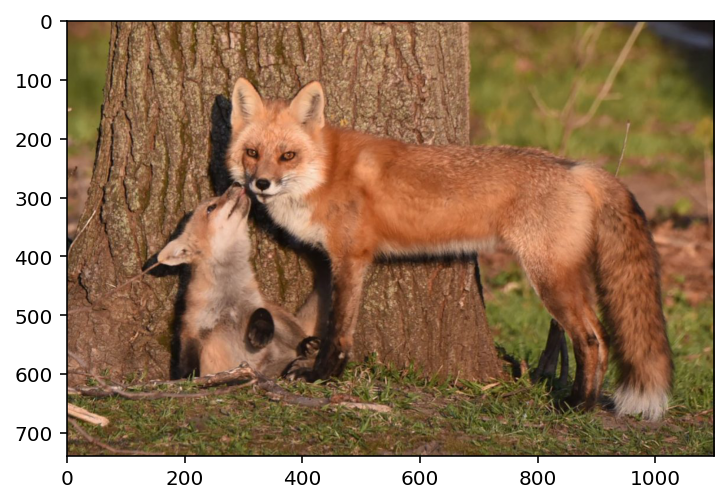

In [13]:
plt.plot()
plt.imshow(im)

In [14]:
img = transform(im).unsqueeze(0)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 180, 180])


In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()

In [15]:
backbone = Backbone()#.to(device)
encoder = EncoderModule()#.to(device)
model = Joiner(backbone, encoder, batch_size=10, hidden_dim=512, image_h=H, image_w=W)

In [16]:
for param in model.parameters():
  param.requires_grad = True

In [26]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
#model = model.to(device)

In [23]:
#model(img.to(device))
#layer_weights = model.backbone.backbone.layer1[0].conv1.weight

In [31]:
epochs = 15
running_loss_history = [] # training loss - to generate a plot
running_corrects_history = [] # traning accuracy
val_running_loss_history = [] # validation loss
val_running_corrects_history = [] # validation accuracy

for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
  
    for inputs, labels in training_loader:
        #TRAINING
        #model.float()
        inputs = inputs.to(device) # allow gpu use
        labels = labels.to(device) # allow gpu use
        #print("Labels", labels)
        #outputs, att, sattn, f_map, pos, pattn = model(inputs) #gives the output of the last layer
        outputs = model(inputs)
        #print("Outputs", outputs)
        loss = criterion(outputs, labels) # comparing outputs and labels using the criteria
        #print("Loss", loss)
        
        
        optimizer.zero_grad() #zero the grad
        loss.requires_grad = True
        #print()
        loss.backward() #backpropagation
        #model.float()
        #print(layer_weights == model.backbone.backbone.layer1[0].conv1.weight)
        optimizer.step() #optimize weights 
        #layer_weights = model.backbone.backbone.layer1[0].conv1.weight

        _, preds = torch.max(outputs, 1) # return the index of the maximum value predicted for that image (used to generate the accuracy)
        running_loss += loss.item() # the sum of the loss of all itens
        running_corrects += torch.sum(preds == labels.data) # the sum of correct prediction on an epochs

    else:
        #VALIDATION
        with torch.no_grad(): # to save memory (temporalely set all the requires grad to be false)
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device) # allow gpu use
                val_labels = val_labels.to(device) # allow gpu use
                #val_outputs, att, sattn, f_map, pos, pattn = model(val_inputs) #passes the image through the network and get the output
                val_outputs = model(inputs)
                val_loss = criterion(val_outputs, val_labels) #compare output and labels to get the loss 

                _, val_preds = torch.max(val_outputs, 1) #same as for training
                val_running_loss += val_loss.item() #same as for training
                val_running_corrects += torch.sum(val_preds == val_labels.data) #same as for training

    #TRAINING LOSS AND ACCURACY
    epoch_loss = running_loss/len(training_loader) # the sum of the loss of all itens divided by the number of itens
    epoch_acc = running_corrects.float()/ len(training_loader) # the sum of correct predictions divided by the number of itens
    running_loss_history.append(epoch_loss) #append to respective list
    running_corrects_history.append(epoch_acc) #append to respective list
    
    #VALIDATION LOSS AND ACCURACY
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss) #append to respective list
    val_running_corrects_history.append(val_epoch_acc) #append to respective list
    print("Correct Predictions", running_corrects.float())
    #print("Training dataset len", len(training_loader))
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

Correct Predictions tensor(5009., device='cuda:0')
epoch : 1
training loss: 2.3068, acc 1.0018 
validation loss: 2.3068, validation acc 1.0000 
Correct Predictions tensor(5009., device='cuda:0')
epoch : 2
training loss: 2.3068, acc 1.0018 
validation loss: 2.3065, validation acc 1.0000 
Correct Predictions tensor(5009., device='cuda:0')
epoch : 3
training loss: 2.3068, acc 1.0018 
validation loss: 2.3066, validation acc 1.0000 
Correct Predictions tensor(5009., device='cuda:0')
epoch : 4
training loss: 2.3068, acc 1.0018 
validation loss: 2.3066, validation acc 1.0000 
Correct Predictions tensor(5009., device='cuda:0')
epoch : 5
training loss: 2.3068, acc 1.0018 
validation loss: 2.3067, validation acc 1.0000 
Correct Predictions tensor(5009., device='cuda:0')
epoch : 6
training loss: 2.3068, acc 1.0018 
validation loss: 2.3067, validation acc 1.0000 


KeyboardInterrupt: 

In [ ]:
print("Correct Predictions", running_corrects.float())
print("Training dataset len", len(training_loader))

In [ ]:
print(labels.shape)
print(outputs.shape)
print(loss.shape)